# This notebook shows an example of the regex parsing of the section titles. The parser can be customized to however our final requirements see fit. This uses the separated mini dataframes that will be standard moving forward.

## Only occurences with non-null UTs are used.

## Included later are filtering based on year cutoffs, and then time windows (time windows is not currently very useful until we can get the database back running fast enough to collect historical citation timepoints for each referenced paper).

## Some work on chi-squared tests are also done, but as you'll see, p-vals are 0.0.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as st

import seaborn as sns
from scipy.stats import norm

/Users/Nathan/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:1028: UserWarning: Illegal line #1
	"{\rtf1\ansi\ansicpg1252\cocoartf1404\cocoasubrtf340
"
	in file "/Users/Nathan/.matplotlib/matplotlibrc"
  warnings.warn('Illegal %s' % error_details)
/Users/Nathan/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:1028: UserWarning: Illegal line #2
	"{\fonttbl\f0\fnil\fcharset0 Menlo-Regular;}
"
	in file "/Users/Nathan/.matplotlib/matplotlibrc"
  warnings.warn('Illegal %s' % error_details)
/Users/Nathan/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:1028: UserWarning: Illegal line #3
	"{\colortbl;\red255\green255\blue255;\red27\green29\blue31;\red235\green236\blue237;}
"
	in file "/Users/Nathan/.matplotlib/matplotlibrc"
  warnings.warn('Illegal %s' % error_details)
/Users/Nathan/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:1028: UserWarning: Illegal line #4
	"\margl1440\margr1440\vieww108

In [2]:
from __future__ import division

In [3]:
ref_df_min = pickle.load(open('/Users/Nathan/dataframes_2/dataframes_v3/ref_dataframe_min_full.pkl', 'rb'))
plos_df = pickle.load(open('/Users/Nathan/dataframes_2/dataframes_v3/plos_paper_dataframe_full.pkl', 'rb'))
cite_df = pickle.load(open('/Users/Nathan/dataframes_2/dataframes_v3/citation_dataframe_full.pkl', 'rb'))
result = ref_df_min.join(cite_df, on='reference_UT')
ref_df = result.join(plos_df, on='paper_UT')

In [ ]:
del ref_df_min
del plos_df
del cite_df
del result

In [4]:
# Removing null reference columns (8907763 rows vs 10848620 rows)
ref_df = ref_df.loc[(ref_df['reference_UT']!=-1)]

In [ ]:
def section_regex_parser(ref_df):
# Using regular expressions to sort sections. Reach a concensus on section identification by scanning both section_title and section_title_alt
    import regex as re

    sect_index_dict = {'intro': 0, 'methods': 1, 'results': 2, 'disc': 3, 'res_disc':4, 'concl':5, 'mixed':6, 'na':7}

    intro_re = re.compile(r'(intro)')
    method_re = re.compile(r'(method)')
    results_re = re.compile(r'(results)')
    disc_re = re.compile(r'(disc)')
    concl_re = re.compile(r'(conclu)')
    backgr_re = re.compile(r'(backgr)')
    mater_re = re.compile(r'(mater)')
    count = 0
    judgement = []

    for i in range(len(ref_df)):
        count += 1
        if count%100000 == 0:
            print(count)
        sect = ref_df.iloc[i]['section_title']
        sect_alt = ref_df.iloc[i]['section_title_alt']
        sect_tag = -1
        sect_alt_tag = -1
        sect_final = -1

        if sect == None:
            sect_tag = 'na'
        else:
            if re.search(intro_re, sect.lower()) or re.search(backgr_re, sect.lower()):
                sect_tag = 'intro'

            elif re.search(method_re,sect.lower()) or re.search(mater_re, sect.lower()):
                if re.search(results_re, sect.lower()):
                    sect_tag = 'mixed'

                elif re.search(disc_re, sect.lower()):
                    sect_tag = 'mixed'

                else:
                    sect_tag = 'methods'

            elif re.search(results_re, sect.lower()):
                if re.search(disc_re, sect.lower()):
                    sect_tag = 'res_disc'
                else:
                    sect_tag = 'results'

            elif re.search(disc_re, sect.lower()):
                sect_tag = 'disc'

            elif re.search(concl_re, sect.lower()):
                sect_tag = 'concl'

            else:
                sect_tag = 'na'



        if sect_alt == None:
            sect_alt_tag = 'na'
        else:
            if re.search(intro_re, sect_alt.lower()) or re.search(backgr_re, sect_alt.lower()):
                sect_alt_tag = 'intro'

            elif re.search(method_re, sect_alt.lower()) or re.search(mater_re, sect_alt.lower()):
                if re.search(results_re, sect_alt.lower()):
                    sect_alt_tag = 'mixed'

                elif re.search(disc_re, sect_alt.lower()):
                    sect_alt_tag = 'mixed'

                else:
                    sect_alt_tag = 'methods'

            elif re.search(results_re, sect_alt.lower()):
                if re.search(disc_re, sect_alt.lower()):
                    sect_alt_tag = 'res_disc'
                else:
                    sect_alt_tag = 'results'

            elif re.search(disc_re, sect_alt.lower()):
                sect_alt_tag = 'disc'

            elif re.search(concl_re, sect_alt.lower()):
                sect_alt_tag = 'concl'

            else:
                sect_alt_tag = 'na'



        if sect_tag == sect_alt_tag: # Confident on label
            sect_final = sect_tag
            #ref_df.iloc[i]['regex_sect_index'] = sect_index_dict[sect_tag]

        else:
            if sect_tag == 'na':
                sect_final = sect_alt_tag
                #ref_df.iloc[i]['regex_sect_index'] = sect_index_dict[sect_alt_tag]
            elif sect_alt_tag == 'na':
                sect_final = sect_tag

            elif sect_tag == 'mixed':
                sect_final = sect_alt_tag

            elif sect_alt_tag == 'mixed':
                sect_final = sect_tag

            elif sect_alt_tag == 'concl': # Conclusion is a plos-based standard that includes discussion/results and discussion
                sect_final = sect_tag
            else:
                sect_final = sect_alt_tag

        judgement.append(sect_final)
    return judgement
        #ref_df.iloc[i]['regex_sect_index'] = sect_index_dict[sect_final]

In [6]:
judgement = section_regex_parser(ref_df)
judgement_2 = []
sect_index_dict = {'intro': 0, 'methods': 1, 'results': 2, 'disc': 3, 'res_disc':4, 'concl':5, 'mixed':6, 'na':7}
for i in judgement:
    judgement_2.append(sect_index_dict[i])
ref_df['regex_sect_index'] = judgement_2

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000
6600000
6700000
6800000
6900000
7000000
7100000
7200000
7300000
7400000
7500000
7600000
7700000
7800000
7900000
8000000
8100000
8200000
8300000
8400000
8500000
8600000
8700000
8800000
8900000


In [16]:
import numpy as np
i=0
#k = np.log2(i)
bin_points = []
while i<16:
    k = 2**i
    i+=1
    bin_points.append(k)
bin_points

[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
326394


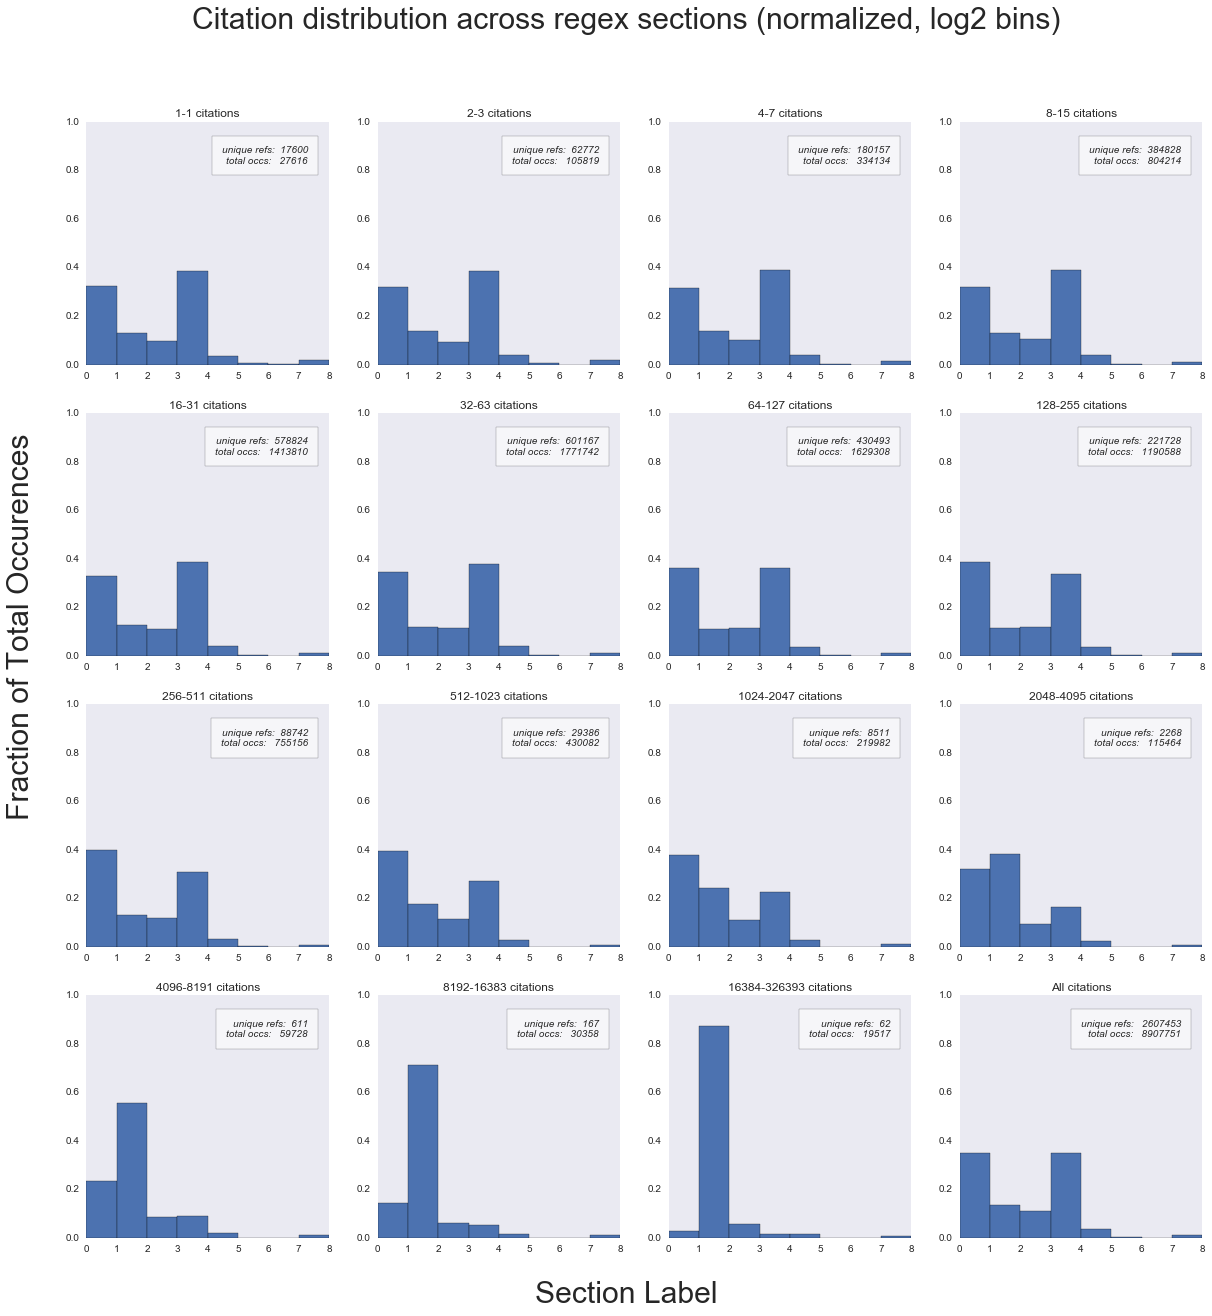

In [8]:
# Non-time-filtered regex-based exploration

fig = plt.figure(figsize=(20,20))
fig.suptitle('Citation distribution across regex sections (normalized, log2 bins)', size=30)
bin_num = 8
subplot_num = 1
hist_list_raw = []
#hist_list = np.array([])
hist_list = []

for i in range(len(bin_points)-1):
    print(subplot_num)
    #print(i)
    if i == len(bin_points)-2:
        upper_bound = int(max(ref_df['cite_count'])+1)
        print(upper_bound)
    else:
        upper_bound = bin_points[i+1]
        #print('asdfasdf')
        

    cite_count_log_list = ref_df.loc[ref_df['cite_count'].isin(range(bin_points[i], upper_bound))]
    title_text = str(bin_points[i]) + '-' + str(upper_bound-1) + ' citations'
    unique_papers = len(cite_count_log_list['reference_UT'].unique())
    total_occs = len(cite_count_log_list)
    ax = fig.add_subplot(4,4,subplot_num)
    
    
    hist1, bins1 = np.histogram(cite_count_log_list['regex_sect_index'], bins= bin_num, range=[0,8])
    hist_list_raw.append(hist1)
    widths1 = np.diff(bins1)
    hist1 = hist1/float(len(cite_count_log_list))
    hist_list.append(hist1)
    #hist_list = np.append(hist_list, hist1, axis=1)
    ax.bar(bins1[:-1], hist1, widths1)
    
    ax.title.set_text(title_text)
    
    subtext1 = 'unique refs:  ' + str(unique_papers)
    subtext2 = 'total occs:   ' + str(total_occs)
    ax.text(7.3, 0.83, subtext1 + '\n' + subtext2, style='italic', horizontalalignment='right',
        bbox={'facecolor':'white', 'alpha':0.6, 'pad':10})

    ax.grid()
    ax.set_ylim([0,1])
    ax.set_xlim([0,7])
    ax.set_xticks([0,1,2,3,4,5,6,7,8])
    subplot_num +=1

# Plotting the distribution for all papers    
cite_count_all = ref_df.loc[(ref_df['cite_count']>=0)]
title_text = 'All citations'
unique_papers = len(cite_count_all['reference_UT'].unique())
total_occs = len(cite_count_all)
ax = fig.add_subplot(4,4,subplot_num)
hist1, bins1 = np.histogram(cite_count_all['regex_sect_index'], bins= bin_num, range=[0,8])
hist_all_raw = hist1
widths1 = np.diff(bins1)
hist1 = hist1/float(len(cite_count_all))
hist_all = hist1
ax.bar(bins1[:-1], hist1, widths1)
ax.title.set_text(title_text)
subtext1 = 'unique refs:   ' + str(unique_papers)
subtext2 = 'total occs:   ' + str(total_occs)

ax.text(7.3, 0.83, subtext1 + '\n' + subtext2, style='italic', horizontalalignment='right',
    bbox={'facecolor':'white', 'alpha':0.6, 'pad':10})
ax.grid()
ax.set_ylim([0,1])
ax.set_xlim([0,7])
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8],['i','m','r','d','rd','c','mx','na',''])


fig.text(0.5, 0.08, 'Section Label', ha='center', size = 30)
fig.text(0.07, 0.55, 'Fraction of Total Occurences', va='center', rotation='vertical', size = 30)

In [9]:
def err_bars_dist_plots(pd_column, folds, total_occs, n_cols):
    err_list = []
    for j in range(folds):
        errs = np.random.choice(pd_column, size = total_occs, replace= True)
        unique_vals, unique_counts = np.unique(errs, return_counts = True)
        err_list_current = []
                
        if len(unique_vals) != n_cols:
            err_list_current = np.array([])
            for jj in range(n_cols):
                if jj in unique_vals:
                    
                    err_list_current = np.append(err_list_current,unique_counts[np.where(unique_vals==jj)])
                else:
                    err_list_current = np.append(err_list_current,0)
            err_list.append(err_list_current)
        else:
            err_list.append(unique_counts)

    err_max = np.array([0]*n_cols)
    err_min = np.array([0]*n_cols)
            
    for k in range(n_cols):
        col = [item[k] for item in err_list]
        err_upper = np.percentile(col, 97.5)
        err_lower = np.percentile(col, 2.5)
        err_max[k] = err_upper
        err_min[k] = err_lower
    #print(err_upper, err_lower)    
    return err_max, err_min

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
326394
[3134129 1216954  994140 3124372  322973   20660     646   93877]
[  3.51842906e-01   1.36617425e-01   1.11603928e-01   3.50747568e-01
   3.62575245e-02   2.31932841e-03   7.25211111e-05   1.05387993e-02]
(array([3129962, 1213731,  992066, 3121598,  321568,   20312,     591,
         93228]), array([3137603, 1220055,  996708, 3128571,  324730,   21063,     704,
         94550]), 8907751, array([  3.51842906e-01,   1.36617425e-01,   1.11603928e-01,
         3.50747568e-01,   3.62575245e-02,   2.31932841e-03,
         7.25211111e-05,   1.05387993e-02]))
[  4.67794845e-04   3.61819723e-04   2.32830936e-04   3.11414183e-04
   1.57727804e-04   3.90671001e-05   6.17439800e-06   7.28578965e-05]


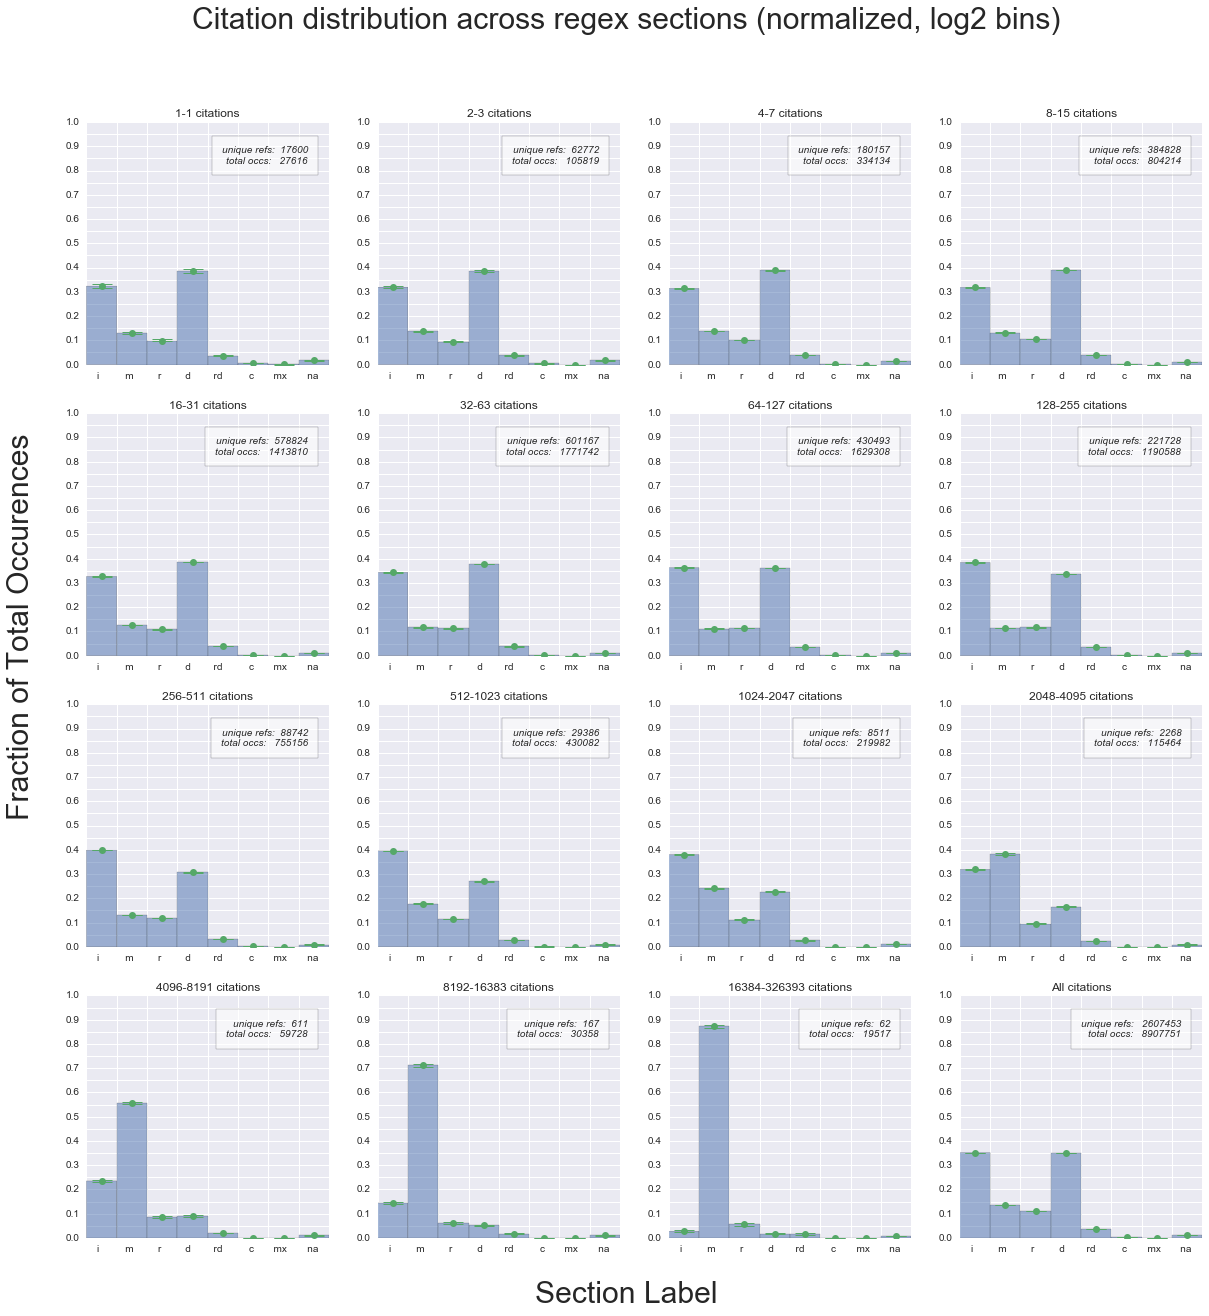

In [43]:
# Non-time-filtered regex-based exploration

fig = plt.figure(figsize=(20,20))
fig.suptitle('Citation distribution across regex sections (normalized, log2 bins)', size=30)
bin_num = 8
subplot_num = 1
hist_list_raw = []
#hist_list = np.array([])
hist_list = []
major_ticks_y = np.arange(0, 1.1, 0.1)
minor_ticks_y = np.arange(0, 1.01, 0.05)
major_ticks_x = np.arange(0, 9, 1)

bin_indices = np.arange(0,9,1)

for i in range(len(bin_points)-1):
    print(subplot_num)
    #print(i)
    if i == len(bin_points)-2:
        upper_bound = int(max(ref_df['cite_count'])+1)
        print(upper_bound)
    else:
        upper_bound = bin_points[i+1]
        #print('asdfasdf')
        

    cite_count_log_list = ref_df.loc[ref_df['cite_count'].isin(range(bin_points[i], upper_bound))]
    title_text = str(bin_points[i]) + '-' + str(upper_bound-1) + ' citations'
    unique_papers = len(cite_count_log_list['reference_UT'].unique())
    total_occs = len(cite_count_log_list)
    ax = fig.add_subplot(4,4,subplot_num)
    
    
    hist1, bins1 = np.histogram(cite_count_log_list['regex_sect_index'], bins= bin_num, range=[0,8])
    err_list = []
    
    for j in range(100):
        errs = np.random.choice(cite_count_log_list['regex_sect_index'], size = total_occs, replace= True)
        unique_vals, unique_counts = np.unique(errs, return_counts = True)
        err_list_current = []
                
        if len(unique_vals) != 8:
            err_list_current = np.array([])
            for jj in range(8):
                if jj in unique_vals:
                    
                    err_list_current = np.append(err_list_current,unique_counts[np.where(unique_vals==jj)])
                else:
                    err_list_current = np.append(err_list_current,0)
            err_list.append(err_list_current)
        else:
            err_list.append(unique_counts)

    err_max = np.array([0]*8)
    err_min = np.array([0]*8)
    #print(err_list)
    for k in range(8):
        col = [item[k] for item in err_list]
        if max(col) >= err_max[k]:
            err_max[k] = float(max(col))
        if min(col) >= err_min[k]:
            err_min[k] = float(min(col))
    #print(unique_counts/total_occs)
    #print(err_max, err_min)
    
    hist_list_raw.append(hist1)
    widths1 = np.diff(bins1)
    hist1 = hist1/float(len(cite_count_log_list))
    hist_list.append(hist1)
    #hist_list = np.append(hist_list, hist1, axis=1)
    sns.distplot(cite_count_log_list['regex_sect_index'], bins1, kde=False, norm_hist=True, hist_kws = {'alpha':0.5},axlabel = False, ax=ax)
    #ax.xaxis.set_ticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
    ax.errorbar([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5], hist_list[i], yerr=[abs(err_min/total_occs-hist_list[i]), abs(err_max/total_occs-hist_list[i])], fmt='o',capsize = 10, capthick=1)
    
    ax.xaxis.set_ticklabels(['    i', '   m', '    r', '   d', '  rd', '    c','  mx', '   na'])
    for tick in ax.xaxis.get_majorticklabels():
        tick.set_horizontalalignment("left")
    ax.title.set_text(title_text)

    subtext1 = 'unique refs:  ' + str(unique_papers)
    subtext2 = 'total occs:   ' + str(total_occs)
    ax.text(7.3, 0.83, subtext1 + '\n' + subtext2, style='italic', horizontalalignment='right',
        bbox={'facecolor':'white', 'alpha':0.6, 'pad':10})

    ax.grid(which='both')
    ax.set_ylim([0,1])
    ax.set_xlim([0,7])

    ax.set_yticks(minor_ticks_y, minor=True)
    ax.set_yticks(major_ticks_y)
    ax.set_xticks(major_ticks_x)
    ax.set_xticks(major_ticks_x, minor=True) # not a typo, just getting around the seaborn grid overwriting
    subplot_num +=1
    
    
    
    
# Plotting the distribution for all papers    
cite_count_all = ref_df.loc[(ref_df['cite_count']>=0)]
title_text = 'All citations'
unique_papers = len(cite_count_all['reference_UT'].unique())
total_occs = len(cite_count_all)
ax = fig.add_subplot(4,4,subplot_num)
hist1, bins1 = np.histogram(cite_count_all['regex_sect_index'], bins= bin_num, range=[0,8])

err_list = []

for j in range(100):
    errs = np.random.choice(cite_count_all['regex_sect_index'], size = total_occs, replace= True)
    unique_vals, unique_counts = np.unique(errs, return_counts = True)
    err_list_current = []

    if len(unique_vals) != 8:
        err_list_current = np.array([])
        for jj in range(8):
            if jj in unique_vals:

                err_list_current = np.append(err_list_current,unique_counts[np.where(unique_vals==jj)])
            else:
                err_list_current = np.append(err_list_current,0)
        err_list.append(err_list_current)
    else:
        err_list.append(unique_counts)

err_max = np.array([0]*8)
err_min = np.array([0]*8)
#print(err_list)
for k in range(8):
    col = [item[k] for item in err_list]
    if max(col) >= err_max[k]:
        err_max[k] = float(max(col))
    if min(col) >= err_min[k]:
        err_min[k] = float(min(col))
        
hist_all_raw = hist1
print(hist1)
widths1 = np.diff(bins1)
hist1 = hist1/float(len(cite_count_all))
print(hist1)
hist_all = hist1
print(err_min, err_max, total_occs, hist_all)
sns.distplot(cite_count_all['regex_sect_index'], bins1, kde=False, norm_hist=True, hist_kws = {'alpha':0.5}, axlabel = False, ax=ax)
print(abs(err_min/total_occs-hist_all))
ax.errorbar([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5], hist_all, yerr=[abs(err_min/total_occs-hist_all), abs(err_max/total_occs-hist_all)], fmt='o',capsize = 10, capthick=1)

#ax.bar(bins1[:-1], hist1, widths1)
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("left")
ax.title.set_text(title_text)

ax.xaxis.set_ticklabels(['    i', '   m', '    r', '   d', '  rd', '    c','  mx', '   na'])
subtext1 = 'unique refs:   ' + str(unique_papers)
subtext2 = 'total occs:   ' + str(total_occs)


ax.text(7.3, 0.83, subtext1 + '\n' + subtext2, style='italic', horizontalalignment='right',
    bbox={'facecolor':'white', 'alpha':0.6, 'pad':10})
ax.grid(which='both')
ax.set_ylim([0,1])
ax.set_xlim([0,7])
ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
ax.set_yticks(minor_ticks_y, minor=True)
ax.set_yticks(major_ticks_y)
ax.set_xticks(major_ticks_x)
ax.set_xticks(major_ticks_x, minor=True) # not a typo, just getting around the seaborn grid overwriting

fig.text(0.5, 0.08, 'Section Label', ha='center', size = 30)
fig.text(0.07, 0.55, 'Fraction of Total Occurences', va='center', rotation='vertical', size = 30)
plt.show()

In [21]:
'''fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
section_curves = np.asarray(hist_list).transpose()
sect_labels = ['Intro', 'Methods', 'Results', 'Disc', 'Results/Disc', 'Conclu', 'Mixed', 'N/A']
for i in range(len(section_curves)):
    plt.plot(section_curves[i], marker='o')
ax.legend(sect_labels)
ax.set_ylim([0,0.5])

major_ticks_y = np.arange(0, 1.01, 0.1)                                              
minor_ticks_y = np.arange(0, 1.01, 0.02)                                               

#plt.set_xticks(major_ticks)                                                       
#plt.set_xticks(minor_ticks, minor=True)                                           
#ax.set_yticks(major_ticks)                                                       
#ax.set_yticks(minor_ticks, minor=True) 

plt.grid(which='both')
ax.set_title('Occurence fraction by section as bin index increases (normalized, log2 bins)', size=20)
ax.set_yaxis(0.5, 0.08, 'Bin number', ha='center', size = 15)
ax.text(0.07, 0.55, 'Fraction of Total Occurences', va='center', rotation='vertical', size = 15)'''

"fig = plt.figure(figsize=(12,8))\nax = fig.add_subplot(111)\nsection_curves = np.asarray(hist_list).transpose()\nsect_labels = ['Intro', 'Methods', 'Results', 'Disc', 'Results/Disc', 'Conclu', 'Mixed', 'N/A']\nfor i in range(len(section_curves)):\n    plt.plot(section_curves[i], marker='o')\nax.legend(sect_labels)\nax.set_ylim([0,0.5])\n\nmajor_ticks_y = np.arange(0, 1.01, 0.1)                                              \nminor_ticks_y = np.arange(0, 1.01, 0.02)                                               \n\n#plt.set_xticks(major_ticks)                                                       \n#plt.set_xticks(minor_ticks, minor=True)                                           \n#ax.set_yticks(major_ticks)                                                       \n#ax.set_yticks(minor_ticks, minor=True) \n\nplt.grid(which='both')\nax.set_title('Occurence fraction by section as bin index increases (normalized, log2 bins)', size=20)\nax.set_yaxis(0.5, 0.08, 'Bin number', ha='center', size

## Now filtering on papers by publication date

In [44]:
def datetime_filler(df, date_column, year_column):
    # Add datetime column to dataframe based on month/season and year columns
    import regex as re
    import datetime
    import math
    numeric = re.compile('[0-9]+')
    alpha = re.compile('[A-Za-z]+')
    month_dict = {'JAN':1, 'FEB': 2, 'MAR':3, 'APR':4, 'MAY':5, 'JUN': 6, 
                  'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT':10, 'NOV': 11, 'DEC': 12,
                 'SPR': 3, 'SUM': 6, 'FAL': 9, 'WIN': 12}
    date_dict = {}
    set_dates = df[date_column].unique()

    for date_u in set_dates:
        date = str(date_u)

        date_field = []
        for i in re.findall(alpha, date):
            date_field.append(i)

        for i in re.findall(numeric, date):
            date_field.append(i)

        if len(date_field) > 2: # No weirdness here, only 2 values max for date field
            print(date_field)

        if len(date_field[0])==1: # There's a single date that is just '0'. Likely a database error/nan
            print(date_field)
            print(date)
        #print(date_field)
        formatted_date = [-1,-1]
        if date_field != ['0']:
            if date_field[0] in month_dict:
                formatted_date[0] = month_dict[date_field[0]]
                if len(date_field)==2:
                    if len(date_field[1])<3:
                        formatted_date[1] = int(date_field[1])

        #print(formatted_date, date_field)
        date_dict[date] = formatted_date
    count = 0    
    dt_col = []
    #dt_dict = {}
    for i,row in ref_df.iterrows():
        date = row[date_column]
        if date in date_dict:
            date_field = date_dict[date]
        else:
            date_field = [-1,-1]

        
        year = row[year_column]
        if not math.isnan(year):
            year = int(year)
        else:
            year = -1

        if year != -1 and date_field != [-1,-1]:
            if date_field[1] != -1:
                dt = datetime.datetime(year, date_field[0], date_field[1])
            else:
                dt = datetime.datetime(year, date_field[0], 15)
        else:
            dt = -1
        #dt_dict[] = dt
        
        dt_col.append(dt)
        count+= 1
        if count%100000 == 0:
            print(count)
            
    return dt_col

In [45]:
dt = datetime_filler(ref_df, 'ref_pub_date', 'ref_pub_year')
dt_plos = datetime_filler(ref_df, 'plos_pub_date', 'plos_pub_year')

['0']
    0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000
6600000
6700000
6800000
6900000
7000000
7100000
7200000
7300000
7400000
7500000
7600000
7700000
7800000
7900000
8000000
8100000
8200000
8300000
8400000
8500000
8600000
8700000
8800000
8900000
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
370000

In [46]:
ref_df['ref_datetime'] = dt
ref_df['plos_datetime'] = dt_plos

In [47]:
# Filter to papers at least 10 years old
import datetime
ten_years= datetime.datetime(2006, 1,1)
non_nan_dates = ref_df[ref_df['ref_datetime']!=-1]
ten_year_df = non_nan_dates[non_nan_dates['ref_datetime']< ten_years]

In [48]:
def dist_profile_plotter_error_bars(ref_df, date_title, directory, fig_num):
    '''Plot distributions given full dataframe with error bars and save it in given directory'''
    fig = plt.figure(figsize=(20,20))
    fig.suptitle('Citation distribution across regex sections (normalized, log2 bins) (' + date_title + ')', size=30)
    bin_num = 8
    subplot_num = 1
    hist_list_raw = []
    #hist_list = np.array([])
    hist_list = []
    count_totals = []
    major_ticks_y = np.arange(0, 1.1, 0.1)
    minor_ticks_y = np.arange(0, 1.01, 0.05)
    major_ticks_x = np.arange(0, 9, 1)

    bin_indices = np.arange(0,9,1)
    error_tracker = []
    for i in range(len(bin_points)-1):
        #print(subplot_num)
        #print(i)
        if i == len(bin_points)-2:
            upper_bound = int(max(ref_df['cite_count'])+1)
            print(upper_bound)
        else:
            upper_bound = bin_points[i+1]
            #print('asdfasdf')


        cite_count_log_list = ref_df.loc[ref_df['cite_count'].isin(range(bin_points[i], upper_bound))]
        title_text = str(bin_points[i]) + '-' + str(upper_bound-1) + ' citations'
        unique_papers = len(cite_count_log_list['reference_UT'].unique())
        total_occs = len(cite_count_log_list)
        ax = fig.add_subplot(4,4,subplot_num)

       
            
        hist1, bins1 = np.histogram(cite_count_log_list['regex_sect_index'], bins= bin_num, range=[0,8])
        hist_list_raw.append(hist1)
        widths1 = np.diff(bins1)
        hist1 = hist1/float(len(cite_count_log_list))
        hist_list.append(hist1)
        count_totals.append(total_occs)
        #hist_list = np.append(hist_list, hist1, axis=1)
        #ax.bar(bins1[:-1], hist1, widths1)
        if len(cite_count_log_list)> 1:
            print(len(cite_count_log_list['regex_sect_index']))
            sns.distplot(cite_count_log_list['regex_sect_index'], bins1, kde=False, norm_hist=True, hist_kws = {'alpha':0.5},axlabel = False, ax=ax)
            try:
                err_max, err_min = err_bars_dist_plots(cite_count_log_list['regex_sect_index'], 100, total_occs, 8)
            except:
                err_max, err_min = np.array([0]*8), np.array([0]*8)
            error_tracker.append([abs(err_min/total_occs-hist1), abs(err_max/total_occs-hist1)])
            #print(abs(err_min/total_occs-hist_list[i]), abs(err_max/total_occs-hist_list[i]))
            #print(err_min, err_max)
            ax.errorbar([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5], hist1, yerr=[abs(err_min/total_occs-hist1), abs(err_max/total_occs-hist1)], fmt='o',capsize = 10, capthick=1)

            ax.xaxis.set_ticklabels(['    i', '   m', '    r', '   d', '  rd', '    c','  mx', '   na'])
            for tick in ax.xaxis.get_majorticklabels():
                tick.set_horizontalalignment("left")

            ax.title.set_text(title_text)

            subtext1 = 'unique refs:  ' + str(unique_papers)
            subtext2 = 'total occs:   ' + str(total_occs)
            ax.text(7.3, 0.83, subtext1 + '\n' + subtext2, style='italic', horizontalalignment='right',
                bbox={'facecolor':'white', 'alpha':0.6, 'pad':10})

            ax.grid(which='both')
            ax.set_ylim([0,1])
            ax.set_xlim([0,7])

            ax.set_yticks(minor_ticks_y, minor=True)
            ax.set_yticks(major_ticks_y)
            ax.set_xticks(major_ticks_x)
            ax.set_xticks(major_ticks_x, minor=True) # not a typo, just getting around the seaborn grid overwriting
        else:
            error_tracker.append([abs(np.array([0]*8)/total_occs-hist1), abs(np.array([0]*8)/total_occs-hist1)])
        subplot_num +=1

    # Plotting the distribution for all papers    
    cite_count_all = ref_df.loc[(ref_df['cite_count']>=0)]
    title_text = 'All citations'
    unique_papers = len(cite_count_all['reference_UT'].unique())
    total_occs = len(cite_count_all)
    ax = fig.add_subplot(4,4,subplot_num)
    
    hist1, bins1 = np.histogram(cite_count_all['regex_sect_index'], bins= bin_num, range=[0,8])
    hist_all_raw = hist1
    widths1 = np.diff(bins1)
    hist1 = hist1/float(len(cite_count_all))
    hist_all = hist1
    #ax.bar(bins1[:-1], hist1, widths1)
    if len(cite_count_all)>1:
        sns.distplot(cite_count_all['regex_sect_index'], bins1, kde=False, norm_hist=True, hist_kws = {'alpha':0.5}, axlabel = False, ax=ax)
        try:
            err_max, err_min = err_bars_dist_plots(cite_count_all['regex_sect_index'], 100, total_occs, 8)
        except:
            err_max, err_min = np.array([0]*8), np.array([0]*8)
        error_tracker.append([abs(err_min/total_occs-hist_all), abs(err_max/total_occs-hist_all)])
        ax.errorbar([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5], hist_all, yerr=[abs(err_min/total_occs-hist_all), abs(err_max/total_occs-hist_all)], fmt='o',capsize = 10, capthick=1)

        ax.xaxis.set_ticklabels(['    i', '   m', '    r', '   d', '  rd', '    c','  mx', '   na'])
        for tick in ax.xaxis.get_majorticklabels():
            tick.set_horizontalalignment("left")

        ax.title.set_text(title_text)
        subtext1 = 'unique refs:   ' + str(unique_papers)
        subtext2 = 'total occs:   ' + str(total_occs)

        ax.text(7.3, 0.83, subtext1 + '\n' + subtext2, style='italic', horizontalalignment='right',
            bbox={'facecolor':'white', 'alpha':0.6, 'pad':10})
        ax.grid(which='both')
        ax.set_ylim([0,1])
        ax.set_xlim([0,7])

        ax.set_yticks(minor_ticks_y, minor=True)
        ax.set_yticks(major_ticks_y)
        ax.set_xticks(major_ticks_x)
        ax.set_xticks(major_ticks_x, minor=True) # not a typo, just getting around the seaborn grid overwriting
    else:
        error_tracker.append([abs(np.array([0]*8)/total_occs-hist_all), abs(np.array([0]*8)/total_occs-hist_all)])
        
    fig.text(0.5, 0.08, 'Section Label', ha='center', size = 30)
    fig.text(0.07, 0.55, 'Fraction of Total Occurences', va='center', rotation='vertical', size = 30)

    hist_list_raw.append(hist_all_raw)
    hist_list.append(hist_all)
    count_totals.append(total_occs)

    plt.savefig(directory+'section_hist_'+date_title+'_'+str(fig_num))
    plt.close()
    return hist_list, np.asarray(hist_list_raw), count_totals, error_tracker

In [49]:
def dist_profile_plotter(ref_df, year_title):
    '''Plot distributions given full dataframe, no error bars or file save'''
    fig = plt.figure(figsize=(20,20))
    fig.suptitle('Citation distribution across regex sections (normalized, log2 bins) (' + year_title + ')', size=30)
    bin_num = 8
    subplot_num = 1
    hist_list_raw = []
    #hist_list = np.array([])
    hist_list = []
    count_totals = []

    for i in range(len(bin_points)-1):
        print(subplot_num)
        #print(i)
        if i == len(bin_points)-2:
            upper_bound = int(max(ref_df['cite_count'])+1)
            print(upper_bound)
        else:
            upper_bound = bin_points[i+1]
            #print('asdfasdf')


        cite_count_log_list = ref_df.loc[ref_df['cite_count'].isin(range(bin_points[i], upper_bound))]
        title_text = str(bin_points[i]) + '-' + str(upper_bound-1) + ' citations'
        unique_papers = len(cite_count_log_list['reference_UT'].unique())
        total_occs = len(cite_count_log_list)
        ax = fig.add_subplot(4,4,subplot_num)


        hist1, bins1 = np.histogram(cite_count_log_list['regex_sect_index'], bins= bin_num, range=[0,8])
        hist_list_raw.append(hist1)
        widths1 = np.diff(bins1)
        hist1 = hist1/float(len(cite_count_log_list))
        hist_list.append(hist1)
        count_totals.append(total_occs)
        #hist_list = np.append(hist_list, hist1, axis=1)
        ax.bar(bins1[:-1], hist1, widths1)

        ax.title.set_text(title_text)

        subtext1 = 'unique refs:  ' + str(unique_papers)
        subtext2 = 'total occs:   ' + str(total_occs)
        ax.text(7.3, 0.83, subtext1 + '\n' + subtext2, style='italic', horizontalalignment='right',
            bbox={'facecolor':'white', 'alpha':0.6, 'pad':10})

        ax.grid()
        ax.set_ylim([0,1])
        ax.set_xlim([0,7])
        ax.set_xticks([0,1,2,3,4,5,6,7,8])
        subplot_num +=1

    # Plotting the distribution for all papers    
    cite_count_all = ref_df.loc[(ref_df['cite_count']>=0)]
    title_text = 'All citations'
    unique_papers = len(cite_count_all['reference_UT'].unique())
    total_occs = len(cite_count_all)
    ax = fig.add_subplot(4,4,subplot_num)
    hist1, bins1 = np.histogram(cite_count_all['regex_sect_index'], bins= bin_num, range=[0,8])
    hist_all_raw = hist1
    widths1 = np.diff(bins1)
    hist1 = hist1/float(len(cite_count_all))
    hist_all = hist1
    ax.bar(bins1[:-1], hist1, widths1)
    ax.title.set_text(title_text)
    subtext1 = 'unique refs:   ' + str(unique_papers)
    subtext2 = 'total occs:   ' + str(total_occs)

    ax.text(7.3, 0.83, subtext1 + '\n' + subtext2, style='italic', horizontalalignment='right',
        bbox={'facecolor':'white', 'alpha':0.6, 'pad':10})
    ax.grid()
    ax.set_ylim([0,1])
    ax.set_xlim([0,7])
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8],['i','m','r','d','rd','c','mx','na',''])


    fig.text(0.5, 0.08, 'Section Label', ha='center', size = 30)
    fig.text(0.07, 0.55, 'Fraction of Total Occurences', va='center', rotation='vertical', size = 30)
    
    hist_list_raw.append(hist_all_raw)
    hist_list.append(hist_all)
    count_totals.append(total_occs)
    return hist_list, np.asarray(hist_list_raw), count_totals

In [50]:
def log2_curves_plot(hist_list, error_tracker, date_title, directory, fig_num):
    '''Plot curves given output of dist_profile_plotter_error_bars - needs the histogram list output and error_tracker, 
    to get the error plotted in this type of plot'''
    
    fig = plt.figure(figsize=(12,8))
    section_curves = np.asarray(hist_list).transpose()
    sect_labels = ['Intro', 'Methods', 'Results', 'Disc', 'Results/Disc', 'Conclu', 'Mixed', 'N/A']

    err_mins = [item[0] for item in error_tracker]
    err_maxs = [item[1] for item in error_tracker]
    err_min_list = []
    err_max_list = []
    for k in range(len(err_mins[0])):
        err_min_list.append([item[k] for item in err_mins])
        err_max_list.append([item[k] for item in err_maxs])
    colors = sns.color_palette("husl", 8)
    for i in range(len(section_curves)):
        #ax.fill_between(x, 0, 1, where=y > theta, facecolor='green', alpha=0.5, transform=trans)
        
        plt.plot(section_curves[i], color = colors[i], marker = 'o')
        plt.fill_between([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], -np.array(err_min_list[i])+section_curves[i], np.array(err_max_list[i])+section_curves[i], color = colors[i], alpha = 0.5)
        #plt.plot(np.array(err_min_list[i])+section_curves[i], marker='+')
        #plt.plot(np.array(err_max_list[i])+section_curves[i], marker='+')
        #sns.tsplot(section_curves[i])
        #plt.errorbar([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], section_curves[i], yerr=[err_min_list[i], err_max_list[i]], fmt='o',capsize = 10, capthick=1)
        #print(section_curves)
    plt.legend(sect_labels, loc='upper left')
    
    plt.ylim([0,1.0])
    plt.xlim([0,15])
    fig.suptitle('Section occurence fraction vs. citation bin (normalized, log2 bins) (' + date_title + ')' , size=16)
    fig.text(0.5, 0.08, 'Bin number', ha='center', size = 15)
    fig.text(0.07, 0.55, 'Fraction of Total Occurences', va='center', rotation='vertical', size = 15)
    plt.savefig(directory+'section_line_graph_'+date_title+'_'+str(fig_num))
    plt.close()

In [51]:
def time_filtered_hist_plotter(ref_df,year,month,day,column,older=True, first_dist_basis = True):
    
    dt = datetime.datetime(year,month,day)
    non_nan_dates = ref_df[ref_df[column]!=-1]
    if older:
        filtered_df = non_nan_dates[non_nan_dates[column]< dt]
    else:
        filtered_df = non_nan_dates[non_nan_dates[column]> dt]

    n_year_hist_list, hist_list_raw, count_totals, error_tracker = dist_profile_plotter_error_bars(filtered_df, str(year))
    
    log2_curves_plot(n_year_hist_list, error_tracker, str(year))
    #chisqs, p_vals = chisquare_tester(hist_list_raw[:, 0:6]) # Only selecting the first five columns (to avoid the small population/un-useful section labels)
    chisqs, p_vals = chisquare_tester(np.asarray(n_year_hist_list)[:, 0:4], count_totals, first_dist_basis = first_dist_basis)
    #print(hist_list, hist_list_raw)
    return chisqs, p_vals

In [52]:
#../plots
def time_filtered_hist_plotter_save_figs(ref_df,year,month,day,column, directory, fig_num, older=True, first_dist_basis = True):
    
    dt = datetime.datetime(year,month,day)
    non_nan_dates = ref_df[ref_df[column]!=-1]
    if older:
        filtered_df = non_nan_dates[non_nan_dates[column]< dt]
    else:
        filtered_df = non_nan_dates[non_nan_dates[column]> dt]

    n_year_hist_list, hist_list_raw, count_totals, error_tracker = dist_profile_plotter_error_bars(filtered_df, str(year), directory, fig_num)
    
    log2_curves_plot(n_year_hist_list, error_tracker, str(year), directory, fig_num)
    #chisqs, p_vals = chisquare_tester(hist_list_raw[:, 0:6]) # Only selecting the first five columns (to avoid the small population/un-useful section labels)
    chisqs, p_vals = chisquare_tester(np.asarray(n_year_hist_list)[:, 0:4], count_totals, first_dist_basis = first_dist_basis)
    #print(hist_list, hist_list_raw)
    return chisqs, p_vals

1876
7629
31276
114436
316766
601566
734521
622407
426405
250082
131280
68965
31708
20130
61215
9130


IOError: [Errno 2] No such file or directory: u'../plots/citation_count_conditioning/section_hist_2006_1.png'

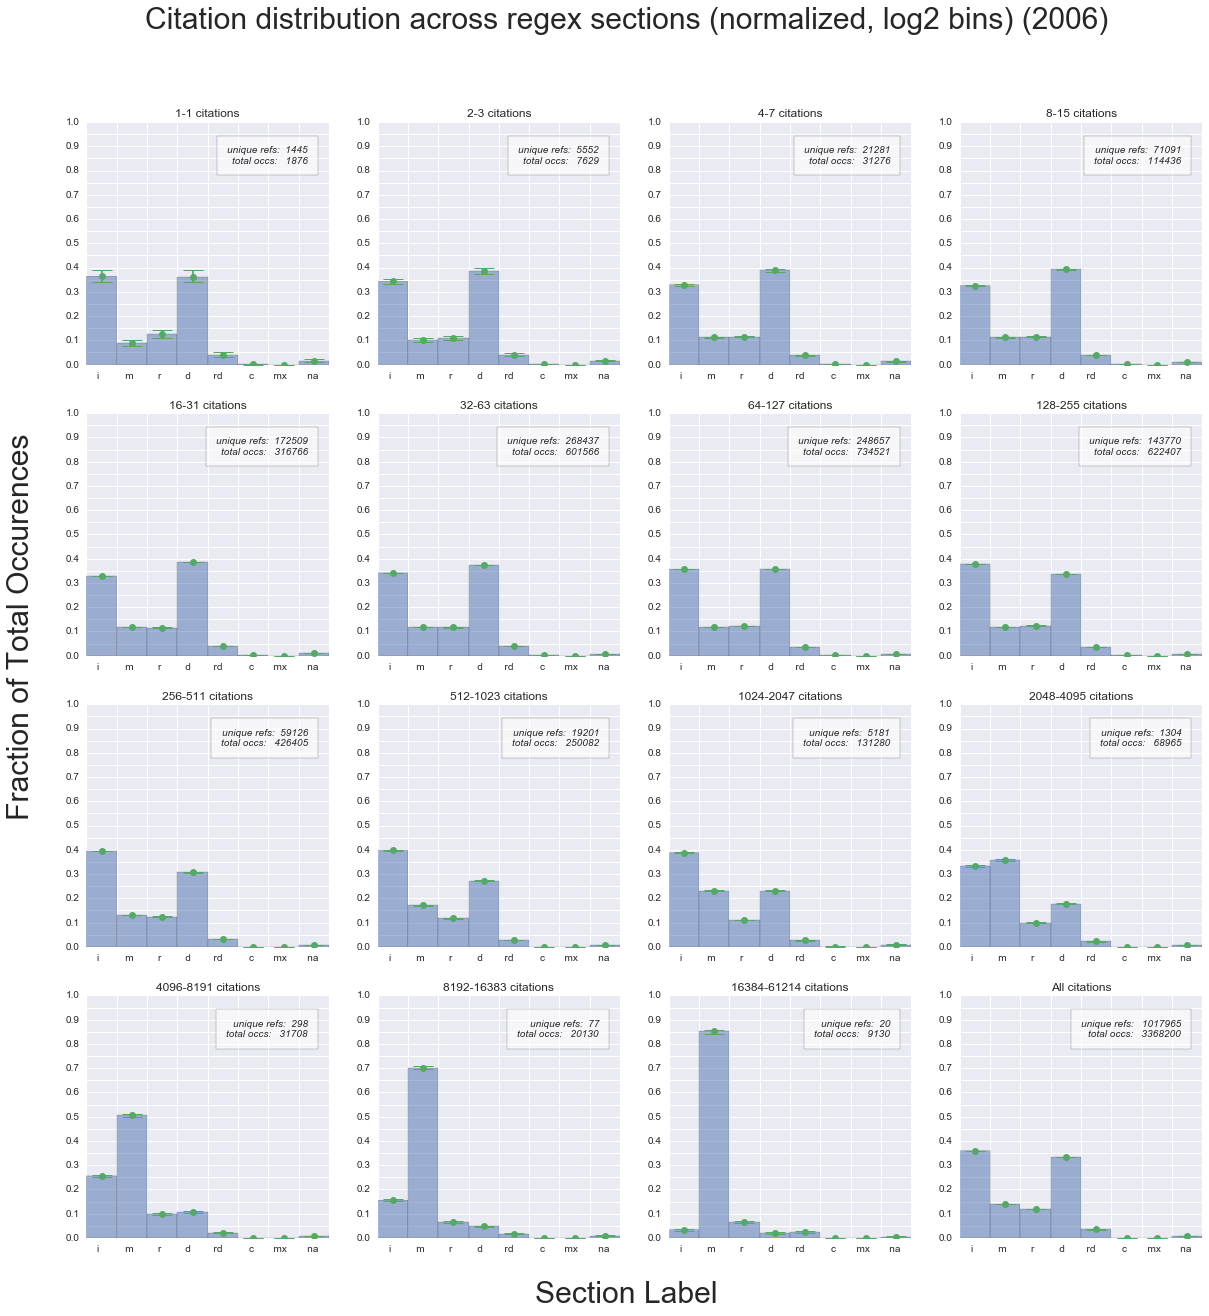

In [53]:
fig_dir = '../plots/citation_count_conditioning/'
time_filtered_hist_plotter_save_figs(ref_df,2006,1,1,'ref_datetime', fig_dir, 1, older=True, first_dist_basis = True)

In [55]:
min_plos_date = 2005
max_plos_date = 2016
min_ref_date = 1990
max_ref_date = 2016
plos_window = 5
ref_window = 5
count = 0
year_list = []
for i in range(max_plos_date-min_plos_date-plos_window+1):
    #print(i + min_plos_date, i+min_plos_date+plos_window)
    for j in range(max_ref_date-min_ref_date-ref_window+1):
        #print(j + min_ref_date, j+min_ref_date+ref_window)
        year_list.append([i + min_plos_date, i+min_plos_date+plos_window, j + min_ref_date, j+min_ref_date+ref_window])
        count+=1
    print(' ')
print(count)

 
 
 
 
 
 
 
154


In [41]:
fig_dir = '../plots/'
save_itc_hists(ref_df, fig_dir)

1
8152691
7783160
19053
80105
272883
688193
1244989
1578516
1455137
1054107
662563
371852
183104
94367
44529
21621
61215
11935


In [57]:
time_filtered_hist_plotter(ref_df,2006,1,1,'ref_datetime')

TypeError: dist_profile_plotter_error_bars() takes exactly 4 arguments (2 given)

In [58]:
import itertools
import scipy.stats as sps

try:
    from itertools import izip as zip
except ImportError: # will be 3.x series
    pass

def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)

def chisquare_tester(hist_list, count_totals, first_dist_basis = True):
    
    chisqs = []
    p_vals = []
    
    if first_dist_basis == True:
        i=0
    else:
        i=1
        
    for x, y in pairwise(hist_list):
    
        first_dist = x*count_totals[i]
        second_dist = y*count_totals[i]
        #print(first_dist,second_dist)
        #score, p = sps.chisquare(second_dist,first_dist, ddof = 0)
        score, p, dof, expctd = sps.chi2_contingency([list(first_dist),list(second_dist)])
        print(dof)
        chisqs.append(score)
        p_vals.append(p)
        i+=1
    return chisqs, p_vals

In [59]:
def chisq_matrix(hist_list, count_totals):
    '''From the histogram output of one of the distribution plotters, create a matrix plot of p values, color-coded
    to show which distributions in that filtering are significantly different according to a Bonferroni-adjusted 
    threshold
    '''
    chisqs = []
    p_vals = []
    for i in range(len(hist_list)):
        first_dist = hist_list[i]*count_totals[i]
        for j in range(len(hist_list)):
            second_dist = hist_list[j]*count_totals[j]
            score, p, dof, expctd = sps.chi2_contingency([list(first_dist),list(second_dist)])
            chisqs.append(round(score,2))
            p_vals.append(p)
    chisqs_np = np.asarray(chisqs)
    chisqs_rs = chisqs_np.reshape(16,16)
    p_vals_np = np.asarray(p_vals)
    p_vals_rs = p_vals_np.reshape(16,16)
    return chisqs_rs, p_vals_rs

In [60]:
def time_filtered_hist_plotter_matrix(ref_df,year, month, day, column, older=True, first_dist_basis = True):
    '''This takes a single day to split either the reference or the PLOS column, and the older variable tells which
    direction to include in the filtering, default to entries older than tbe date input
    '''
    dt = datetime.datetime(year,month,day)
    non_nan_dates = ref_df[ref_df['ref_datetime']!=-1]
    
    if older:
        filtered_df = non_nan_dates[non_nan_dates[column]< dt]
    else:
        filtered_df = non_nan_dates[non_nan_dates[column]> dt]

    n_year_hist_list, hist_list_raw, count_totals = dist_profile_plotter(filtered_df, str(year))
    
    log2_curves_plot(n_year_hist_list, str(year))
    chisqs, p_vals = chisq_matrix(np.asarray(n_year_hist_list)[:, 0:4], count_totals)
    #print(hist_list, hist_list_raw)
    return chisqs, p_vals

In [61]:
def time_filtered_hist_plotter_matrix_dual_window(ref_df,plos_dt_max, plos_dt_min, ref_dt_max, ref_dt_min, directory, fig_num, first_dist_basis = True):
    '''This plotter is the most flexible, taking in upper and lower bounds for both PLOS papers and reference papers, 
    and then plotting the distribution, histogram, chi-squared test, and saving them.
    '''
    #dt = datetime.datetime(year,month,day)
    non_nan_dates = ref_df[(ref_df['ref_datetime']!=-1) & (ref_df['plos_datetime']!=-1)]
    print(len(non_nan_dates))
    filtered_df = non_nan_dates[(non_nan_dates['ref_datetime']> ref_dt_min) & (non_nan_dates['ref_datetime']<= ref_dt_max) & (non_nan_dates['plos_datetime']> plos_dt_min) & (non_nan_dates['plos_datetime']<= plos_dt_max)]
    print(len(filtered_df))
    title = 'plos_' + str(plos_dt_min.year) +'-'+ str(plos_dt_max.year) + '_ref_' + str(ref_dt_min.year) +'-'+ str(ref_dt_max.year)
    
    n_year_hist_list, hist_list_raw, count_totals, error_tracker = dist_profile_plotter_error_bars(filtered_df, title, directory, fig_num)
    #n_year_hist_list, hist_list_raw, count_totals = dist_profile_plotter(filtered_df, title)
    
    log2_curves_plot(n_year_hist_list, error_tracker, title, directory, fig_num)
    #log2_curves_plot(n_year_hist_list, title)
    try:
        chisqs, p_vals = chisq_matrix(np.asarray(n_year_hist_list)[:, 0:4], count_totals)
        
    except:
        chisqs, p_vals = [None, None]
    try:
        make_chi2_table(chisqs, p_vals, title, directory, fig_num)
    except:
        pass
    #print(hist_list, hist_list_raw)
    return chisqs, p_vals

In [62]:
def make_chi2_table(chisqs, p_vals, date_title, directory, fig_num):
   
    p_val_pd = pd.DataFrame(p_vals)
    cmap1 = ListedColormap(['w'])
    #p_val_pd[p_val_pd > (0.05/(16*15/2))] = 1
    p_val_pd[p_val_pd < (0.05/(16*15/2))] = 0
    plt.figure(figsize = (15,12))
    plt.title('P-values ' + date_title)
    sns.heatmap(p_val_pd, annot=True)
    sns.heatmap(p_val_pd, mask =p_val_pd>(0.05/(16*15/2)), cmap=cmap1, cbar=False,annot=True)
    

    plt.savefig(directory+'chi_squared_'+date_title+'_'+str(fig_num))

In [63]:
dt_window = [datetime.datetime(2017,1,1), datetime.datetime(2013,1,1), datetime.datetime(2009,1,1), datetime.datetime(2006,1,1)]

1876
7629
31276
114436
316766
601566
734521
622407
426405
250082
131280
68965
31708
20130
61215
9130


IOError: [Errno 2] No such file or directory: u'../plots/citation_count_conditioning/section_hist_2006_1.png'

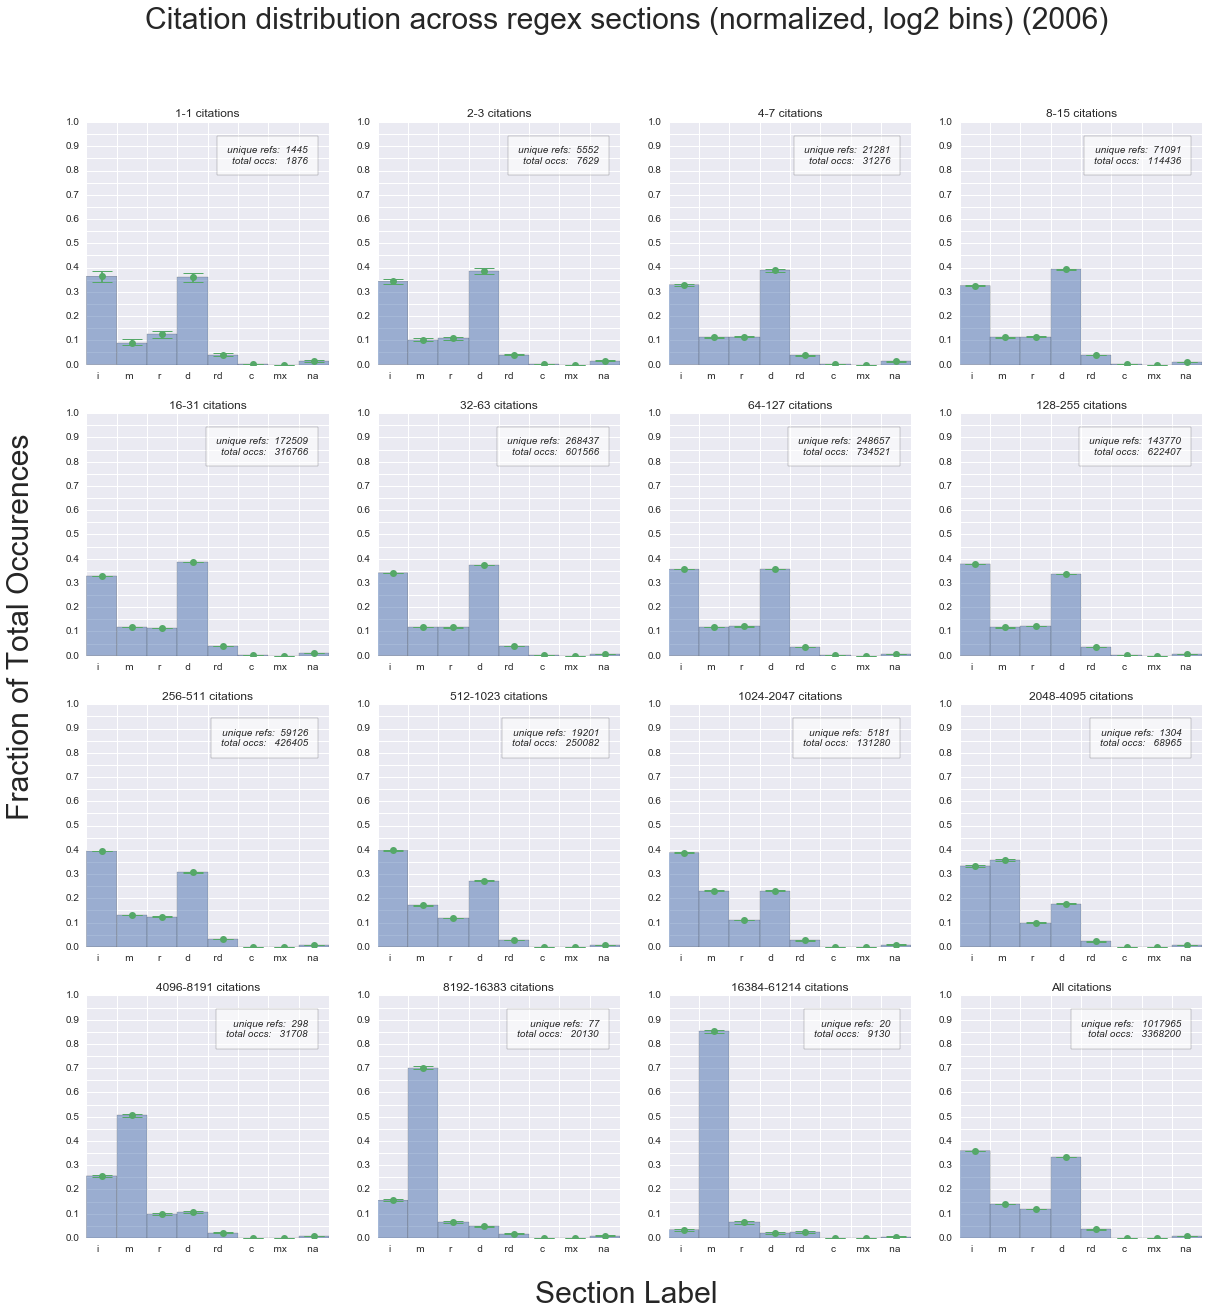

In [64]:
fig_dir = '../plots/citation_count_conditioning/'
time_filtered_hist_plotter_save_figs(ref_df,2006,1,1,'ref_datetime', fig_dir, 1, older=True, first_dist_basis = True)

8152691
950623
872
3997
17430
63236
155908
226266
198438
131524
76888
42481
19108
8737
4334
905
49347
489


IOError: [Errno 2] No such file or directory: u'../plots/citation_count_conditioning/section_hist_plos_2013-2017_ref_2006-2009_1.png'

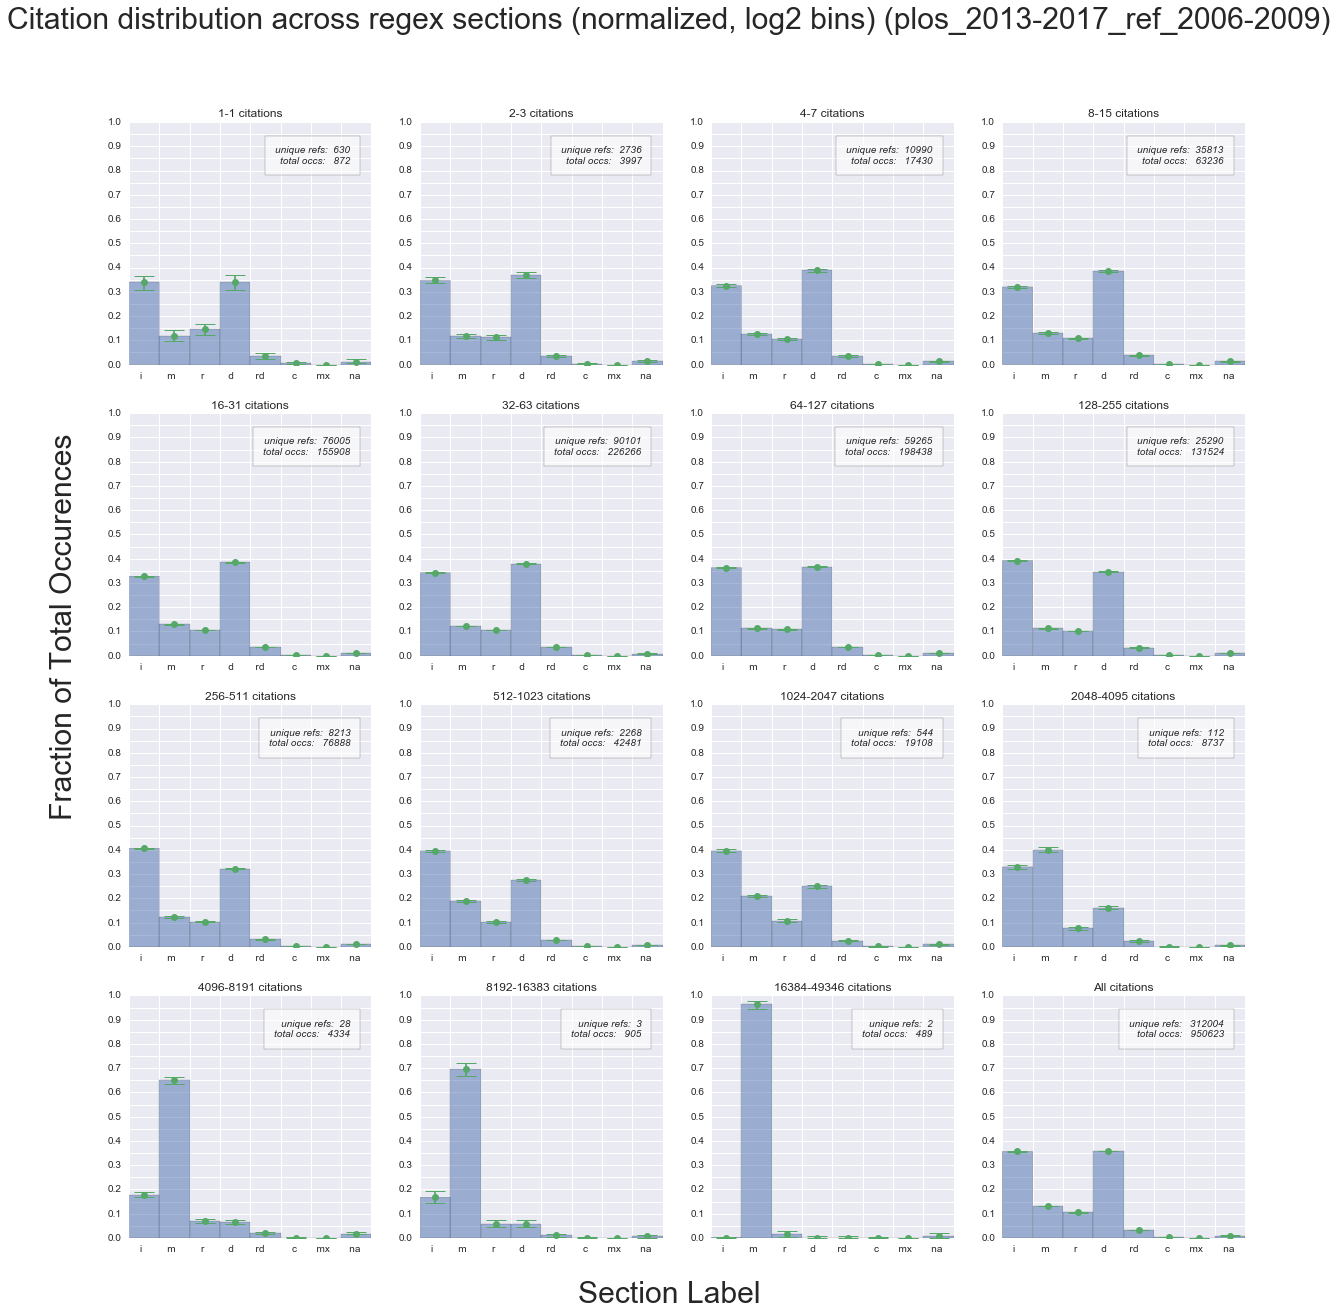

In [65]:
a,b = time_filtered_hist_plotter_matrix_dual_window(ref_df,dt_window[0],dt_window[1],dt_window[2], dt_window[3], fig_dir, 1)

In [ ]:
def highlight_p_val(val):

    color = 'red' if val < (0.05/(16*15/2)) else 'black'
    return 'color: %s' % color

In [ ]:
chisq_pd = pd.DataFrame(a)
chisq_pd

In [ ]:
p_val_pd = pd.DataFrame(b)
s = p_val_pd.style.applymap(highlight_p_val)
s

In [ ]:
plt.figure(figsize =(20,10))
sns.heatmap(p_val_pd, annot=True, vmax=0.9)

In [ ]:
# No scaling
time_filtered_hist_plotter(ref_df,2006,1,1,'ref_datetime')

In [ ]:
# Basis of scaling by the second distribution
time_filtered_hist_plotter(ref_df,2006,1,1,'ref_datetime', first_dist_basis = False)

In [ ]:
time_filtered_hist_plotter(ref_df,1995,1,1,'ref_datetime')

In [ ]:
time_filtered_hist_plotter(ref_df,2000,1,1,'ref_datetime')

In [ ]:
time_filtered_hist_plotter(ref_df,2005,1,1,'ref_datetime')

In [ ]:
time_filtered_hist_plotter(ref_df,2010,1,1,'ref_datetime')

In [ ]:
chisqs, p_vals = time_filtered_hist_plotter(ref_df,2005,1,1,'ref_datetime')
chisqs, p_vals

In [66]:
# Now sliding window - citations from papers published in the x preceding years of the PLOS paper
def time_filtered_hist_plotter_window(ref_df,years):
    '''Looking from the perspective of PLOS papers, filter to only the preceding years, as indicated in the years variable
    '''
    #plos_dt = datetime.datetime(year,month,day)
    
    non_nan_dates = ref_df[ref_df['ref_datetime']!=-1]
    non_nan_dates = non_nan_dates[non_nan_dates['plos_datetime']!=-1]

    filtered_df = non_nan_dates[non_nan_dates['plos_datetime'] - non_nan_dates['ref_datetime'] <= datetime.timedelta(round(365*years))]

    n_year_hist_list, hist_list_raw = dist_profile_plotter(filtered_df, str(years)+ '-year window')
    
    log2_curves_plot(n_year_hist_list, str(years)+ '-year window')
    chisqs, p_vals = chisquare_tester(hist_list_raw[:, 0:6]) # Only selecting the first five columns (to avoid the small population/un-useful section labels)
    #print(hist_list, hist_list_raw)
    return chisqs, p_vals

In [84]:
time_filtered_hist_plotter_window(ref_df,0.5)

KeyboardInterrupt: 

In [ ]:
time_filtered_hist_plotter_window(ref_df,1)
time_filtered_hist_plotter_window(ref_df,3)
time_filtered_hist_plotter_window(ref_df,5)
time_filtered_hist_plotter_window(ref_df,10)
time_filtered_hist_plotter_window(ref_df,20)

In [56]:
def save_itc_hists(ref_df, directory):
    '''Old form of the program, where time windows are only accounted for by year and must be changed within the body
    of the program. Better formations have been shown
    '''
    min_plos_date = 2005
    max_plos_date = 2016
    min_ref_date = 1900
    max_ref_date = 2016
    plos_window = 11
    ref_window = 116

    fig_num = 1
    count = 0
    year_list = []
    for i in range(max_plos_date-min_plos_date-plos_window+1):
        for j in range(max_ref_date-min_ref_date-ref_window+1):
            year_list.append([i + min_plos_date, i + min_plos_date+plos_window, j + min_ref_date, j + min_ref_date+ref_window])
            count+=1
    print(count)
    for years in year_list:
        plos_dt_min = datetime.datetime(years[0],1,1)
        plos_dt_max = datetime.datetime(years[1],1,1)
        ref_dt_min = datetime.datetime(years[2],1,1)
        ref_dt_max = datetime.datetime(years[3],1,1)
        if ref_dt_min >= plos_dt_max:
            pass
        else:
            time_filtered_hist_plotter_matrix_dual_window(ref_df,plos_dt_max, plos_dt_min, ref_dt_max, ref_dt_min, directory, fig_num)
            fig_num+=1